#TP de classification de texte

## Imports nécessaires

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from bs4 import BeautifulSoup
import regex as re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk import word_tokenize
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download("punkt")
from nltk.stem import WordNetLemmatizer
from collections import Counter
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Attention, Input, Embedding, LSTM, Dense, Flatten

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Dropout

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Chargement des données


---



In [ ]:
!pip install kaggle
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 93% 24.0M/25.7M [00:01<00:00, 26.9MB/s]
100% 25.7M/25.7M [00:01<00:00, 16.2MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [ ]:
df = pd.read_csv("IMDB Dataset.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Nettoyage et prétraitement des textes

In [ ]:
eng_stopword = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(data,col_name):
  data[f"prep_{col_name}"] = data[col_name].copy()
  new_data = data[f"prep_{col_name}"]
  new_data = new_data.apply(lambda x: BeautifulSoup(x).get_text())
  new_data = new_data.apply(lambda x: x.lower())
  new_data = new_data.apply(lambda x: re.sub(r'[^a-zA-ZÀ-ÿ\s]',' ', x))
  new_data = new_data.apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split() if word not in eng_stopword]))



  data[f"prep_{col_name}"] = new_data


preprocess_text(df,"review")

<ipython-input-6-5329402d84d4>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  new_data = new_data.apply(lambda x: BeautifulSoup(x).get_text())


## Première tokenisation

Le but de cette section est de trouver des paramètres intéressants pour la taille du vocabulaire à considérer ainsi que la taille évaluée d'un commentaire

<Axes: >

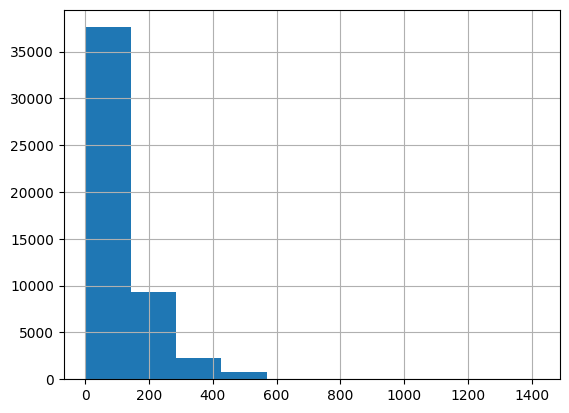

In [ ]:

df["token_review"] = df["prep_review"].apply(word_tokenize)

#Find the most useful padding
df["lenseq"]= df["token_review"].apply(lambda x: len(x))
df["lenseq"].hist()


Plus de 90 % des commentaires font moins de 500 mots alors qu'une grande majorité en fait moins de 100. 500 ainsi apparaît comme une découpe décente

In [ ]:
filtered_df = df[df["lenseq"]<=500].copy()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_df["token_review"])

In [ ]:
def find_word_number_with_recurrence_threshold(tokenizer,min_occurrences):
  sorted_values = sorted(tokenizer.word_counts.values(),reverse=True)
  best_index = 0
  for i in range(len(sorted_values)):
    if sorted_values[i] < min_occurrences:
      best_index = i
      break
  return best_index




En fonction de nos besoins, on peut utiliser le compteur de mots du Tokenizeur pour trouver le nombre de mots à garder pour que le mot le moins fréquent ait le nombre désiré

54557
43893
38083
34224
31355
29150
27259
25720
24373
23304
22277
21391
20568
19864
19198
18595
18044
17530
17033
16565
16154
15771
15386
15028
14695
14374
14065
13785
13505
13255
13021
12777
12535
12345
12095
11912
11702
11518
11337
11163
10991
10840
10683
10532
10402
10252
10105
9972
9844
9729
9604
9504
9387
9294
9212
9106
9007
8895
8790
8684
8585
8482
8399
8320
8240
8131
8042
7978
7904
7829
7744
7672
7593
7523
7453
7388
7337
7277
7227
7171
7123
7056
7015
6955
6890
6841
6787
6726
6673
6627
6573
6543
6483
6431
6379
6327
6272
6222
6175
6142
6099
6058
6021
5986
5952
5906
5861
5835
5796
5764
5731
5697
5666
5631
5590
5553
5512
5481
5445
5415
5383
5358
5321
5287
5251
5218
5180
5145
5122
5095
5063
5034
5010
4987
4967
4939
4915
4893
4863
4845
4820
4801
4782
4749
4735
4723
4703
4673
4643
4627
4606
4591
4578
4554
4540
4526
4509
4483
4459
4440
4422
4402
4377
4355
4336
4314
4296
4274
4257
4239
4219
4196
4174
4153
4134
4115
4090
4072
4055
4038
4016
3998
3984
3968
3955
3941
3929
3911
3896
3882
386

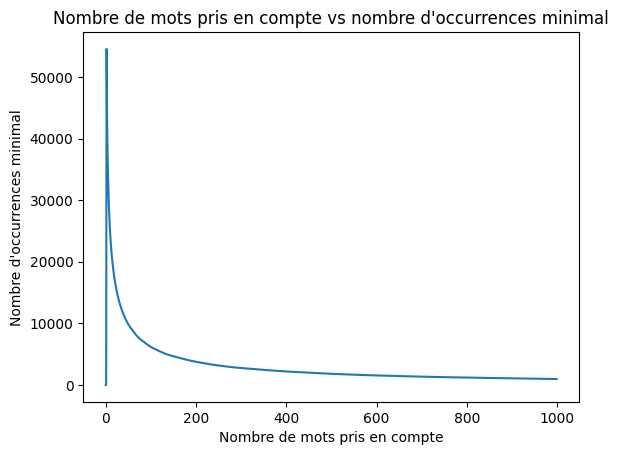

In [ ]:
indexes = [i for i in range(1000) ]
values = [find_word_number_with_recurrence_threshold(tokenizer,i) for i in indexes]

plt.plot(indexes, values)
plt.title("Nombre de mots pris en compte vs nombre d'occurrences minimal")
plt.xlabel("Nombre de mots pris en compte")
plt.ylabel("Nombre d'occurrences minimal")
plt.show()

In [ ]:
full_corpus = [word for seq in filtered_df["token_review"] for word in seq]
counter = Counter(full_corpus)
len(counter.keys())

90964

De manière arbitraire, nous avons décidé de garder les mots qui apparaissent moins de 5 fois

In [ ]:
least_occurent_words = set([key for key, value in counter.items() if value < 5])
filtered_df["token_review"] = filtered_df["token_review"].apply(lambda x: [word for word in x if word not in least_occurent_words])

In [ ]:
full_corpus = [word for seq in filtered_df["token_review"] for word in seq]
counter = Counter(full_corpus)
len(counter.keys())

34224

In [ ]:
filtered_df["review_joined"] = filtered_df["token_review"].apply(lambda x: " ".join(x))

## Feature engineering

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_df["token_review"])
filtered_df["feature"] = tokenizer.texts_to_sequences(filtered_df["token_review"])

In [ ]:
label_encoder = LabelEncoder()
filtered_df["sentiment"] = label_encoder.fit_transform(filtered_df["sentiment"])

features = filtered_df["feature"].tolist()  # Convert to list
padded_features = pad_sequences(features, maxlen=500, value=0)



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_features, filtered_df["sentiment"], test_size=0.2, random_state=42,stratify=filtered_df["sentiment"])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


## Création du modèle

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
LR_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)


In [ ]:
model_lstm = Sequential([
    Embedding(input_dim=38006, output_dim=128, input_length=500),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


callbacks = [early_stopping, LR_decay]

In [ ]:
#model_lstm.fit(X_train, y_train, epochs = 100, validation_split = 0.2,callbacks = callbacks)

Epoch 1/100
107/995 [==>...........................] - ETA: 2:02 - loss: 0.5335 - accuracy: 0.7243

KeyboardInterrupt: 

In [ ]:
#model_lstm.save_weights("model_lstm.h5")

In [ ]:
#from google.colab import drive
#drive.mount('drive/')
#us_dataset_path="drive/My Drive/HakimKNN/"

## Evaluation du modèle

In [ ]:
model_lstm.predict(X_test)

In [ ]:
model_lstm.evaluate(X_test, y_test)

In [ ]:
confusion_matrix(y_test, model_lstm.predict(X_test).round())
accuracy_score(y_test, model_lstm.predict(X_test).round())

In [ ]:
auc = roc_auc_score(y_test, model_lstm.predict(X_test))
print("AUC:", auc)

In [ ]:
def preprocess_input(text):
  text = BeautifulSoup(text).get_text()
  text = text.lower()
  text = re.sub(r'[^a-zA-ZÀ-ÿ\s]','', text)
  text = " ".join([word for word in text.split() if word not in eng_stopword])
  text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
  return text


def predict_sentiment(text):
  encoded_text = tokenizer.texts_to_sequences([preprocess_input(text)])
  padded_text = pad_sequences(encoded_text, maxlen=500, value=0)
  prediction = model_lstm.predict(padded_text)
  if prediction >= 0.5:
    return "Positive"
  else:
    return "Negative"

predict_sentiment("You could be surprised by what I've seen from this actor. I'll see the next movie , if there's one !")

In [ ]:

'''
model_save_path = "drive/My Drive/HakimKNN/lstm_model.h5"

# Sauvegarde du modèle
model_lstm.save(model_save_path)
print(f"Modèle sauvegardé à l'emplacement : {model_save_path}")
'''

## Modèle LSTM avec Attention

In [ ]:

input_layer = Input(shape=(500,))
embedding_layer = Embedding(input_dim=38006, output_dim=128)(input_layer)
lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)
attention_layer = Attention()([lstm_layer, lstm_layer])
flatten_layer = Flatten()(attention_layer)
output_tensor = Dense(1, activation="sigmoid")(flatten_layer)# à vous de voir

model_lstm_attention = Model(inputs=input_layer, outputs=output_tensor)

In [ ]:
model_lstm_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_attention.fit(X_train, y_train, epochs = 100, validation_split = 0.2,callbacks = callbacks, lr=10e-5)


Epoch 1/100
995/995 [==============================] - 92s 88ms/step - loss: 0.3593 - accuracy: 0.8299 - val_loss: 0.2785 - val_accuracy: 0.8895 - lr: 0.0010
Epoch 2/100
995/995 [==============================] - 46s 46ms/step - loss: 0.1569 - accuracy: 0.9411 - val_loss: 0.3621 - val_accuracy: 0.8772 - lr: 0.0010
Epoch 3/100
995/995 [==============================] - 35s 35ms/step - loss: 0.0739 - accuracy: 0.9726 - val_loss: 0.4666 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 4/100
995/995 [==============================] - 32s 32ms/step - loss: 0.0268 - accuracy: 0.9910 - val_loss: 0.7327 - val_accuracy: 0.8786 - lr: 1.0000e-04


In [ ]:
model_lstm_attention.save("lstm_attention_tf.h5")